<h1 align='center'> DNA Data Analytics<h1>


### Table of Contents

- <a href="#1">1. Introduction</a>
    + <a href="#1.1"> 1.1 Variable Descriptions</a><br>
    + <a href="#1.3"> 1.2 Library Import</a><br>
    + <a href="#1.2"> 1.3 Data Import</a><br>
    + <a href="#1.3"> 1.4 Visualization</a><br><br>

    
    
- <a href="#2">2. Modeling on Raw Data</a><br>
    + <a href="#2.1"> 2.1 Random Forest</a><br>
    + <a href="#2.2"> 2.2 Gradient Boosting</a><br>
    + <a href="#2.3"> 2.3 Support Vector Machine</a><br><br>

- <a href="#3">3. Feature Engineering</a>
    + <a href="#3.1"> 3.1 Column Pooling</a><br>
    + <a href="#3.2"> 3.2 Feature Selection</a><br>
    + <a href="#3.3"> 3.3 Data Augmentation</a><br><br>
    
- <a href="#4">4. Unsupervised Learning - Anomaly Detection</a>




## 1. Introduction <a id='1'></a>



This problem simulates two datasets (DS) of patients whose blood samples whose cell-free DNA has been investigated. The data format does not reflect any clinical format and is heavily optimized to provide you with an easy-to-access test environment.



### 1. 1 Variable Descriptions <a id='1.1'></a>

Patients and their diagnoses are plotted in columns, starting in column E; mutational targets are plotted in rows.
Each mutational target represents a specific location on the DNA of the patient. It is represented by a % frequency that indicates who frequently mutated the location is. The higher the frequency, the higher the % of mutated DNA copies at this specific location are found.<br><br>
Each location is part of a region (column A) and has a relative position in that region (Column B). A relative position “2” means it is located directly next to “3” in the same region. Each region is part of a Gene (column C).
Some targets in DS A have no assigned region, which means they don't exist in DS B.<br>
Targets that are located on the same gene have a higher probability to have a similar impact on disease compared to targets located on other genes. Certain genes might be more important for disease detection than others. However, individual targets can have a (much) higher impact than other targets in the same region and gene.<br>  
As with all biological data, both datasets can contain high level of noise, including potential technical errors. In addition, control patients can potentially have early stage disease that hasn’t been diagnosed yet. However, they are unlikely to have progressed disease A or B.<br>   
DS B contains far more targets than DS A. It contains most targets from DS A. You can (but don’t have to) use the additional targets in DS B to devise additional strategies to identify disease candidates.

## 1.2 Library Import

This library is written for further analysis. I will import this module from another python script.

In [ ]:

from __future__ import division

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, Imputer, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split

import itertools

class Base():
    '''
    Defined to import the dataset.
    '''
    def __init__(self, file):
        self.file = file
        self.nameA = "Dataset A 16"
        self.nameB = "Dataset B 24"
        self.nA = 16
        self.nB = 24
        
        self.getData()
        
    def getData(self):
        self.dataA = pd.read_excel(self.file, sheet_name=self.nameA, header=None)
        print('Data A Loaded')
        self.dataB = pd.read_excel(self.file, sheet_name=self.nameB, header=None)
        print('Data B Loaded')

class Import(Base):
    '''
    This class is created to reuse the general preprocessing steps.
    
    *parameter
    
    file: enter the name of the excel file that stores the DNA mutation ratio and disease information of the subjects 
    '''
    def __init__(self, file):
        super().__init__(file)
    
    def organize(self):
        '''
        Transfrom the unorganized dataset to be model inputs.
        '''
        rowStart = 2
        colStart = 4
        DNAlistA = set(self.dataA.iloc[rowStart:, 2].unique())
        DNAlistB = set(self.dataB.iloc[rowStart:, 2].unique())
        self.DNAinter = list(DNAlistA.intersection(DNAlistB))
        
        def new_col(data):
            colNames = data.iloc[rowStart:, 2].apply(str) + "-" + \
                        data.iloc[rowStart:, 0].apply(lambda x: str(x).split('_')[1] if not pd.isnull(x) else '00') +\
                        "-" + data.iloc[rowStart:, 1].apply(str)
            return colNames
            
        def get_trans(data, n):
            colNames = new_col(data)
            data_T = data.iloc[rowStart:, colStart:n+colStart].T
            data_T.columns = colNames
            return data_T
        
        def get_target(data, n):
            target = data.iloc[0, colStart:n+colStart].apply(lambda x: x.split(' ')[1] if not pd.isnull(x) else 'N').reset_index(drop=True)
            return target
        
        self.targetA = get_target(self.dataA, self.nA) 
        self.targetB = get_target(self.dataB, self.nB)
        
        self.dataA = get_trans(self.dataA, self.nA).reset_index().drop('index', axis=1)
        self.dataB = get_trans(self.dataB, self.nB).reset_index().drop('index', axis=1)
        
        self.dataA['isC'] = (self.targetA == 'C').apply(int)
        self.dataB['isC'] = (self.targetB == 'C').apply(int)
        
        def encode(target):
            nClass = len(np.unique(self.targetB))
            codeDic = dict(zip(np.unique(self.targetB), range(nClass)))
            codeDic['C'] = codeDic['N']
            
            y = np.zeros(len(target)*nClass)
            for i, target in enumerate(target):
                y[nClass*i + codeDic[target]] = 1
            return y.reshape(-1, nClass)
        
        self.yA, self.yB = map(encode, [self.targetA, self.targetB])
        self.organized = 1
        
        # missing values
        imputer = Imputer(strategy='median')
        self.columnsA = self.dataA.columns
        self.columnsB = self.dataB.columns
        self.dataA = pd.DataFrame(imputer.fit_transform(self.dataA), columns=self.columnsA)
        self.dataB = pd.DataFrame(imputer.fit_transform(self.dataB), columns=self.columnsB)
        
        return self.dataA, self.dataB, self.DNAinter
      
      
class Modeling():
    '''
    This is a helper class to test classifiers based on f1 scores.
    '''
    def __init__(self):
        self.score = []
    
    def fit(self, X_train, y_train):
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        self.best_f1 = -1

    def test(self, clf, X_test, y_test):
        clf.fit(X_test, y_test)
        pred = clf.predict(X_test)
        self.score.append(f1_score(y_test, pred, average='weighted'))
        
        f1 = f1_score(y_test, pred, average='weighted')
        if f1 == max(self.score) and f1 > self.best_f1:
            self.best_clf = clf
            self.best_f1 = f1

    def plot(self, name, param):
        sns.set_style("darkgrid")
        plt.figure(figsize=(7,7))
        plt.plot(param, self.score)
        plt.xlabel(name)
        plt.ylabel('f1-score')
        plt.title('f1-score vs. {0}: {1}'.format(name, param))
        self.score = []
        self.best_f1 = -1
        
        
class Preprocess():
    '''
    This class is to preprocess the imported dataset for classifiers.
    '''
    def __init__(self, aug_ratio=100000):
        assert isinstance(aug_ratio, int) and aug_ratio > 1, Exception('Enter a valid integer for the augment ratio')
        self.aug_ratio = aug_ratio
        self.n_row_A = 16
        
    def fit(self, dataA, dataB, y_train, y_test, DNAlist):
        self.dataA = dataA.copy()
        self.dataB = dataB.copy()
        self.DNAlist = DNAlist.copy()
        self.y_train = y_train.copy()
        self.y_test = y_test.copy()
        
    def get_total(self, kind='max'):
        assert kind in set(['mean', 'median', 'max']), Exception('Enter a valid option for the kind')
        self.kind = kind

        total = []
        for gene in [self.dataA, self.dataB]:
            new_data = []
            
            for n in self.DNAlist:
                geneTemp = [x for x in list(gene.columns) if x.split('-')[0] == str(n)]
            
                if self.kind == 'mean':
                    new_data.append(np.mean(gene[geneTemp], axis=1))
                
                elif self.kind == 'median':
                    new_data.append(np.median(gene[geneTemp], axis=1))
                
                elif self.kind == 'max':
                    new_data.append(np.max(gene[geneTemp], axis=1))
            
            if gene.shape[0] == self.n_row_A:
                new_data.append(self.dataA['isC'])
            else:
                new_data.append([0]*gene.shape[0])
            
            scaler = MinMaxScaler()
            this = scaler.fit_transform(np.stack(new_data, axis=1))
            total.append(this)
            
        return tuple(total)
    
    def get_intersection(self):
        total = []
        for gene in [self.dataA, self.dataB]:
            new_data = []
            for n in self.DNAlist:
                geneTemp = [x for x in list(gene.columns) if x.split('-')[0] == str(n)]
                new_data.append(gene[geneTemp])
            
            if gene.shape[0] == self.n_row_A:
                new_data.append(pd.DataFrame(self.dataA['isC']))
            else:
                new_data.append(pd.DataFrame([0]*gene.shape[0]))
            
            total.append(np.concatenate(new_data, axis=1))
            
        return tuple(total)
      
    def augument(self, new_DNAlist):
        total = []
        new_y = []
        target_label = self.y_train.argmax(axis=1)
        
        for label in [0, 1, 2]:
            new_data = []
            
            for n in new_DNAlist:
                geneTemp = [x for x in list(self.dataA.columns) if x.split('-')[0] == str(n)]
                
                this_rows = np.where(target_label==label)[0]
                    
                s = np.std(self.dataA.loc[this_rows, geneTemp].values)
                mu = np.mean(self.dataA.loc[this_rows, geneTemp].values)

                existing_row = np.max(self.dataA.loc[this_rows, geneTemp], axis=1).values.reshape(-1, 1)
                created_row = (np.random.randn(self.aug_ratio*sum(target_label==label)) * s + mu).reshape(-1, 1)
                
                new_data.append(np.concatenate([existing_row, created_row]))
            
            total.append(np.concatenate(new_data, axis=1))
            new_y.extend([label for _ in range((self.aug_ratio+1)*sum(target_label==label))])
            
        def encode(target):
            nClass = len(np.unique(target_label))
            
            y = np.zeros(len(target)*nClass)
            
            for i, target in enumerate(target):
                y[nClass*i + target] = 1
            
            return y.reshape(-1, nClass)
          
        return (np.concatenate(total), encode(new_y))
    
    
### The definitions of two functions below are not original entirely. 
### Some parts were forked from a Kaggle kernel.
### I have lost the link to the original work.
def plot_confusion_mat(cm, classes, cmap=plt.cm.Blues):
    title='Confusion matrix'

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def full_report(model, x, y_true, classes, clf):
    
    one_hot = (clf == 'rf')
        
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict(x).argmax(axis=1) if one_hot else model.predict(x)
    y_true = y_true.argmax(axis=1) if one_hot else y_true

    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true, y_pred)))
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=4))    
    
    # 5. Plot confusion matrix
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    #print(cnf_matrix)
    plot_confusion_mat(cnf_matrix, classes=classes)

### 1. 3 Data Import <a id='1.2'></a>

In [0]:
# Error off
import warnings
warnings.filterwarnings(action='ignore')

# Data Wrangling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling & evaluation
from sklearn import ensemble, svm, linear_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Imputer, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import pickle

# Custom library
from quantgenelib import Import, Preprocess, Modeling, full_report, plot_confusion_mat

import os

In [5]:
# Prepare the data
file_path = '.'
file = Import(os.path.join(file_path, 'quantgene.xlsx'))
dataA, dataB, DNAlist = file.organize()
y_train, y_test = file.yA, file.yB
DNAinter = file.DNAinter

Data A Loaded
Data B Loaded


In [0]:
process = Preprocess()
process.fit(dataA, dataB, y_train, y_test, DNAlist)

### 1. 4 Visualization <a id='1.2'></a>

The data consist of the mutation ratio of each location of DNA.

In [7]:
# A glimpse of the data
dataA.head(10)

,0-00-80,0-00-79,0-00-78,0-00-77,0-00-76,0-00-75,0-00-74,0-00-73,0-00-72,0-00-71,...,13-172-72,13-172-73,13-172-74,13-172-75,13-172-76,13-172-77,13-172-78,13-172-79,13-172-80,isC
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.006579,0.039735,0.033113,0.059603,0.059603,0.019868,0.046358,0.039735,0.0
1,0.000000,0.000000,0.000560,0.000000,0.000553,0.000000,0.000548,0.000000,0.000542,0.000000,...,0.007663,0.003937,0.004032,0.008130,0.004184,0.008511,0.008584,0.008658,0.008658,0.0
2,0.001127,0.001115,0.001100,0.001092,0.001089,0.000000,0.001079,0.001072,0.002131,0.001586,...,0.014440,0.012500,0.003841,0.011719,0.013441,0.013661,0.015257,0.014065,0.014286,1.0
3,0.000544,0.001070,0.000000,0.000000,0.000521,0.000000,0.000000,0.000000,0.000000,0.000501,...,0.020510,0.020619,0.006270,0.019577,0.017525,0.020213,0.022286,0.020220,0.021090,1.0
4,0.000000,0.000424,0.001686,0.000000,0.001668,0.000416,0.001654,0.000000,0.000409,0.000000,...,0.024077,0.019859,0.012134,0.020253,0.009590,0.021634,0.022768,0.022543,0.021432,0.0
5,0.000954,0.000950,0.000943,0.000937,0.000934,0.001857,0.002775,0.000921,0.001835,0.000912,...,0.005714,0.005291,0.015873,0.010582,0.010582,0.010582,0.010582,0.010638,0.016043,1.0
6,0.000000,0.000407,0.002028,0.000403,0.002010,0.000000,0.001995,0.000000,0.000792,0.000000,...,0.013672,0.010631,0.004736,0.009582,0.005618,0.012117,0.010830,0.012382,0.012509,0.0
7,0.000501,0.000498,0.000891,0.000295,0.000392,0.000000,0.000388,0.000193,0.000576,0.000286,...,0.014171,0.011709,0.004204,0.010137,0.008384,0.013261,0.012401,0.013343,0.013825,0.0
8,0.000000,0.000486,0.000000,0.000477,0.000000,0.000472,0.000000,0.000000,0.000000,0.000000,...,0.371941,0.270974,0.268817,0.011834,0.269191,0.012474,0.294549,0.281481,0.287701,0.0
9,0.001056,0.000347,0.000000,0.000000,0.000000,0.000336,0.000334,0.000000,0.000329,0.000000,...,0.005119,0.005236,0.023560,0.015707,0.031496,0.023684,0.010554,0.021108,0.023747,0.0


In [8]:
dataB.head(10)

,1-1-0,1-1-1,1-1-2,1-1-3,1-1-4,1-1-5,1-1-6,1-1-7,1-1-8,1-1-9,...,13-173-8,13-173-7,13-173-6,13-173-5,13-173-4,13-173-3,13-173-2,13-173-1,13-173-0,isC
0,0.001046,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000349,0.0,0.000349,...,0.000000,0.000000,0.000987,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001698,0.000000,0.0,0.000000,0.000566,0.001132,0.0,0.000000,0.0,0.001132,...,0.000000,0.000729,0.002915,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001570,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000523,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000592,0.000000,0.0,0.000592,0.000592,0.000000,0.0,0.000000,0.0,0.001184,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000763,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.001574,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000718,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000762,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000953,0.000000,0.0,0.000000,0.000953,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.001147,0.000287,0.0,0.000000,0.000000,0.000287,0.0,0.000287,0.0,0.000574,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.001191,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000298,...,0.000805,0.000000,0.000402,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.001370,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As mentioned above, the number of DNA locations are more rich in the second dataset. I detect the sparsity of those features indicating the need to control the variance from high-dimensional data. These low signal-noise ratio and high dimensionality compared to the number of data points can make our prediction strongly unstable.

In [0]:
dataA_pool, dataB_pool = process.get_total('max')
dataA_pool_df = pd.DataFrame(dataA_pool, columns=DNAinter+['isC'])
dataB_pool_df = pd.DataFrame(dataB_pool, columns=DNAinter+['isC'])

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <a list of 10 Text yticklabel objects>)

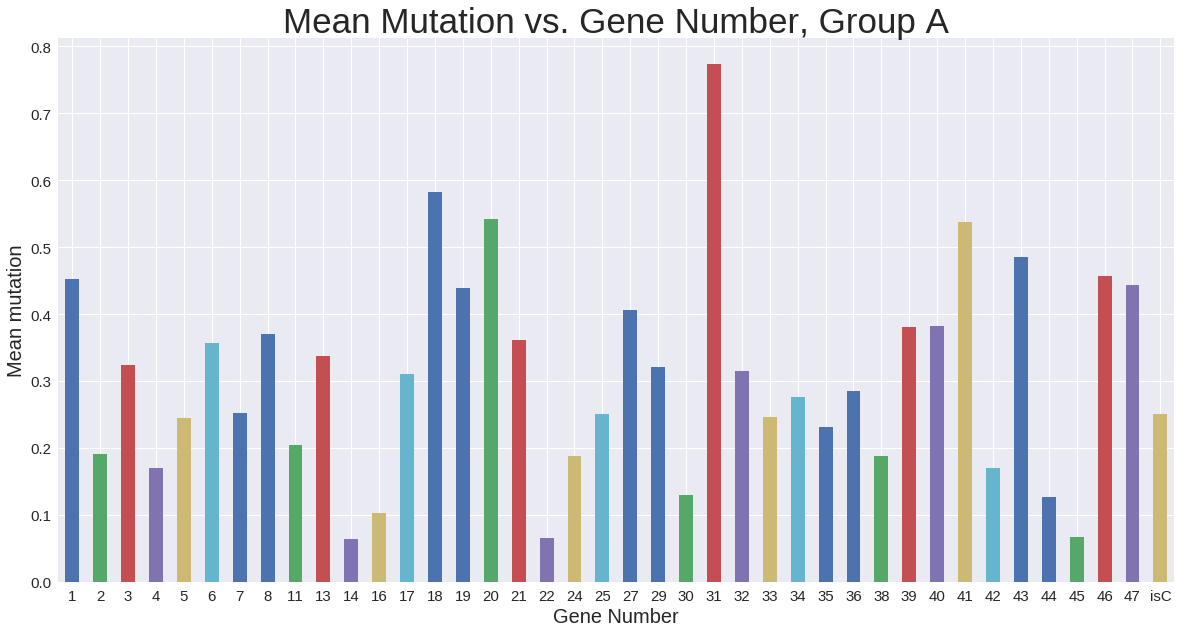

In [10]:
plt.figure(figsize=(20, 10))
np.mean(dataA_pool_df, axis=0).plot(kind='bar', rot='0')
plt.xlabel('Gene Number', fontsize=20)
plt.ylabel('Mean mutation', fontsize=20)
plt.title('Mean Mutation vs. Gene Number, Group A', fontsize=35)
plt.xticks(size=15)
plt.yticks(size=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 <a list of 9 Text yticklabel objects>)

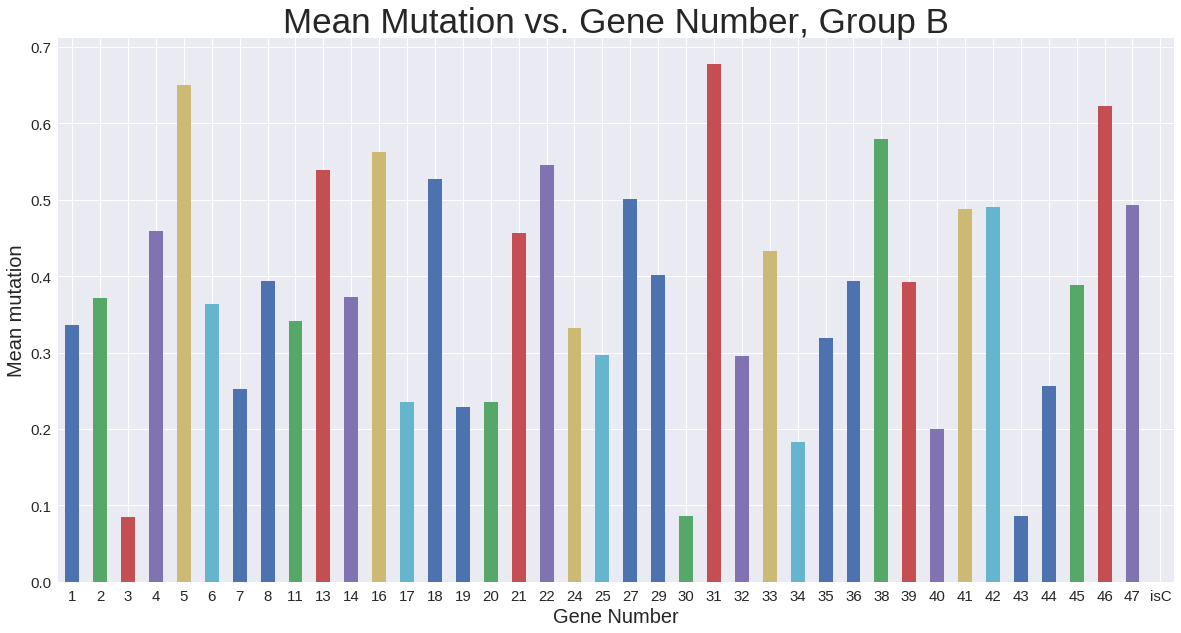

In [11]:
plt.figure(figsize=(20, 10))
np.mean(dataB_pool_df, axis=0).plot(kind='bar', rot='0')
plt.xlabel('Gene Number', fontsize=20)
plt.ylabel('Mean mutation', fontsize=20)
plt.title('Mean Mutation vs. Gene Number, Group B', fontsize=35)
plt.xticks(size=15)
plt.yticks(size=15)

In this plots, we can see how much mutation occured based on the gene numbers that both of the groups share. There are 47 genes in common and the mutation ratio varies among the genes. One more interesting observation is that the mean mutation is larger in the dataset B than in A.

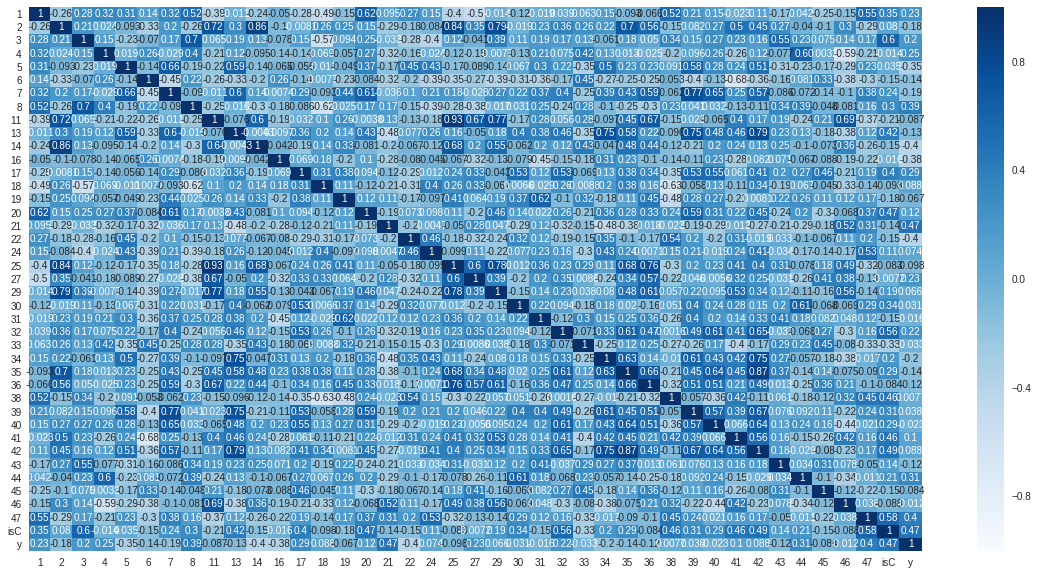

In [12]:
plt.figure(figsize=(20, 10))
dataA_pool_df['y'] = y_train.argmax(axis=1)
sns.heatmap(dataA_pool_df.corr(), annot=True, cmap = plt.cm.Blues)

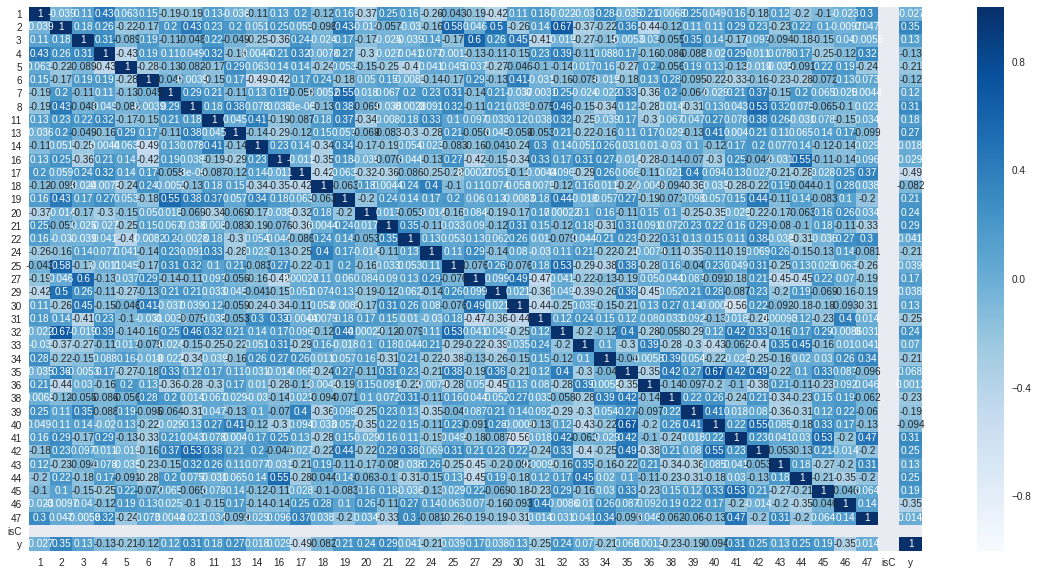

In [13]:
plt.figure(figsize=(20, 10))
dataB_pool_df['y'] = y_test.argmax(axis=1)
sns.heatmap(dataB_pool_df.corr(), annot=True, cmap=plt.cm.Blues)

On these heatmap plots, I detect reasonable amount of correlation especially between the target and other predictors. Even though the given biological dataset contains much noise, it seems there is a certain structure underlying those. The correlation among genes may indicate a need to further decrease dimensions. Feature selection algorithms including PCA could be the way.

<br>  
## 2. Modeling on Raw Data<a id='2'></a>

This is a simple modeling without feature engineering. My custom library, quantgenelib, was loaded to reproduce the resuable parts of the code.

### 2. 1 Random Forest <a id='2.1'></a>

In [0]:
np.random.seed(42)

In [0]:
X_train, X_test = process.get_intersection()
model = Modeling()
model.fit(X_train, y_train)

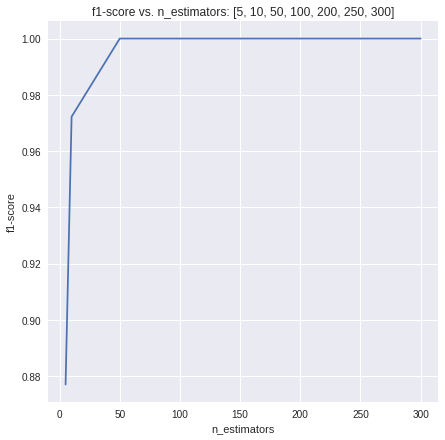

In [16]:
# Random Forest
param = [5, 10, 50, 100, 200, 250, 300]

for n in param:
    clf = ensemble.RandomForestClassifier(n_estimators=n)
    model.test(clf, X_test, y_test)

model.plot('n_estimators', param)

Accuracy : 1.0
Classification Report
             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000         2
          1     1.0000    1.0000    1.0000         2
          2     1.0000    1.0000    1.0000        20

avg / total     1.0000    1.0000    1.0000        24



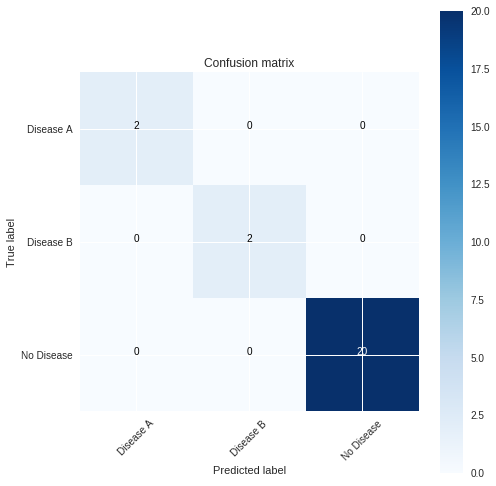

In [17]:
class_list = ['Disease A','Disease B', 'No Disease']
full_report(model.best_clf, X_test, y_test, class_list, clf='rf')

### 2. 2 Gradient Boosting <a id='2.2'></a>

In [0]:
new_y_train = np.argmax(y_train, axis=1)
new_y_test = np.argmax(y_test, axis=1)

model = Modeling()
model.fit(X_train, new_y_train)

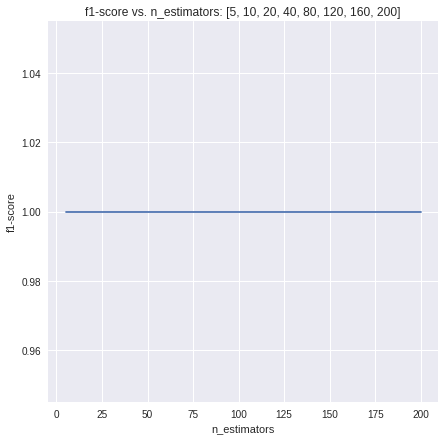

In [19]:
param = [5, 10, 20, 40, 80, 120, 160, 200]

for n in param:
    clf = ensemble.GradientBoostingClassifier(n_estimators=n)
    model.test(clf, X_test, new_y_test)

model.plot('n_estimators', param)

Accuracy : 1.0
Classification Report
             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000         2
          1     1.0000    1.0000    1.0000         2
          2     1.0000    1.0000    1.0000        20

avg / total     1.0000    1.0000    1.0000        24



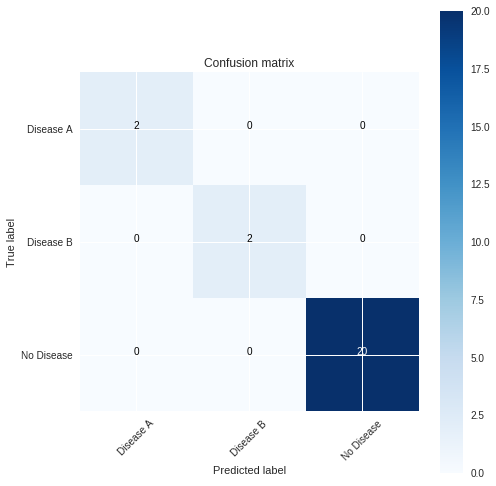

In [20]:
full_report(model.best_clf, X_test, new_y_test, class_list, clf='boosting')

### 2. 3 Support Vector Machine <a id='2.3'></a>

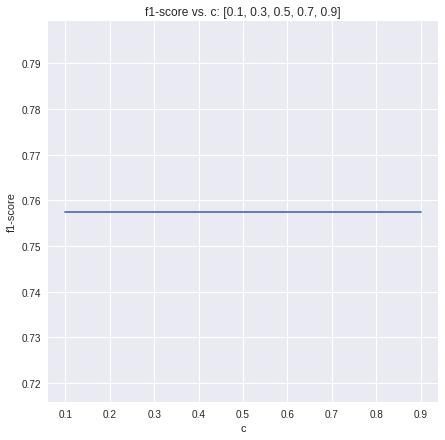

In [21]:
# SVM
param = [x/10 for x in list(range(1, 11, 2))]

for n in param:
    clf = svm.SVC(C=n)
    model.test(clf, X_test, new_y_test)

model.plot('c', param)

Accuracy : 0.8333333333333334
Classification Report
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000         2
          1     0.0000    0.0000    0.0000         2
          2     0.8333    1.0000    0.9091        20

avg / total     0.6944    0.8333    0.7576        24



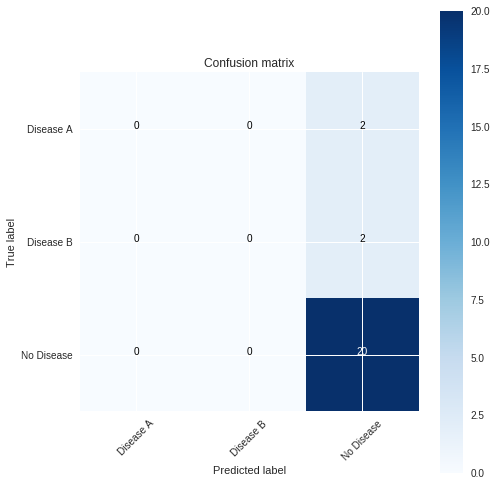

In [22]:
full_report(model.best_clf, X_test, new_y_test, class_list, clf='svm')

### Observation

The random forest and gradient boosting algorithms already achieved good performance on the raw data. However, the number of test data points are no more than 24. It is by no means enough to demonstrate the validity of the models. Support vector machine, on the other hand, could not identify the disease A or B returning zero of sensitivity.

I excluded more flexible models such as neural networks as the training points are extremely low.

## 3. Feature Engineering<a id='3'></a> 

### 3.1 Column Pooling<a id='3.1'></a>   

Despite the acceptable performance of the two algorithms, there is a room for further improvement in this supervised learning. The reason why this extra approach is needed is the lack of test data points as well as of the training data points. Given the limited number of data, I will try to create as generalizable model as possible.

In [0]:
X_train, X_test = process.get_total('max') 
# Please note that I can get 'mean' and 'median' pooling by changing the parameter
# I selected max here because this made the best performance.

model = Modeling()
model.fit(X_train, y_train)

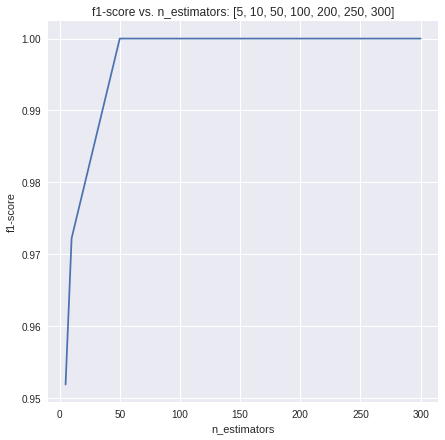

In [24]:
# Random Forest
param = [5, 10, 50, 100, 200, 250, 300]

for n in param:
    clf = ensemble.RandomForestClassifier(n_estimators=n)
    model.test(clf, X_test, y_test)

# For future usage
rf_clf = model.best_clf

model.plot('n_estimators', param)

Accuracy : 1.0
Classification Report
             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000         2
          1     1.0000    1.0000    1.0000         2
          2     1.0000    1.0000    1.0000        20

avg / total     1.0000    1.0000    1.0000        24



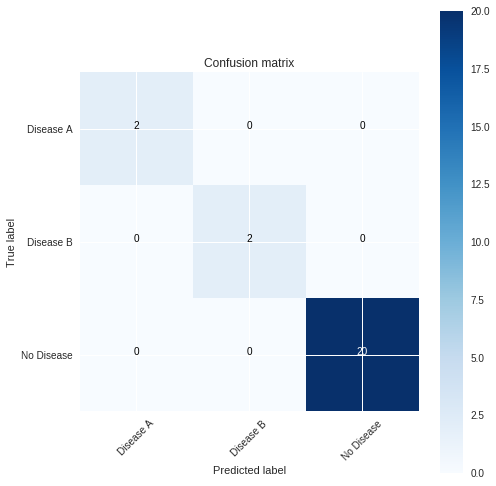

In [25]:
full_report(model.best_clf, X_test, y_test, class_list, clf='rf')

### 3.2 Feature Selection <a id='3.2'></a>   

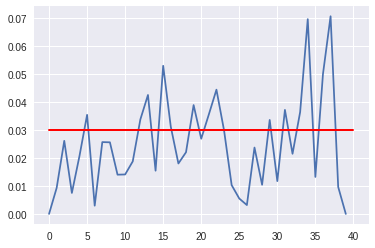

In [26]:
# Let`s consider only those features with importances over 0.03
threshold = 0.03
plt.plot(rf_clf.feature_importances_)
plt.plot([0, 40], [threshold]*2, 'r-', lw=2)

In [0]:
important_cols = [DNAinter[i] for i in np.where(rf_clf.feature_importances_ > threshold)[0]]

process = Preprocess()
process.fit(dataA, dataB, y_train, y_test, important_cols)

X_train, X_test = process.get_total('max')

In [28]:
print("The important gene labels: {}".format(important_cols), " based on random forest")

The important gene labels: [6, 17, 18, 20, 21, 25, 29, 30, 38, 40, 42, 43, 45, 46]  based on random forest


In [29]:
print("{0} columns are selected out of {1}".format(X_train.shape[1], len(DNAinter)))

15 columns are selected out of 39


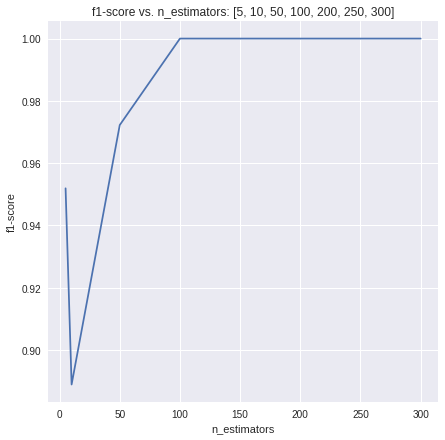

In [30]:
model.fit(X_train, y_train)

# Random Forest
param = [5, 10, 50, 100, 200, 250, 300]

for n in param:
    clf = ensemble.RandomForestClassifier(n_estimators=n)
    model.test(clf, X_test, y_test)

model.plot('n_estimators', param)

Accuracy : 1.0
Classification Report
             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000         2
          1     1.0000    1.0000    1.0000         2
          2     1.0000    1.0000    1.0000        20

avg / total     1.0000    1.0000    1.0000        24



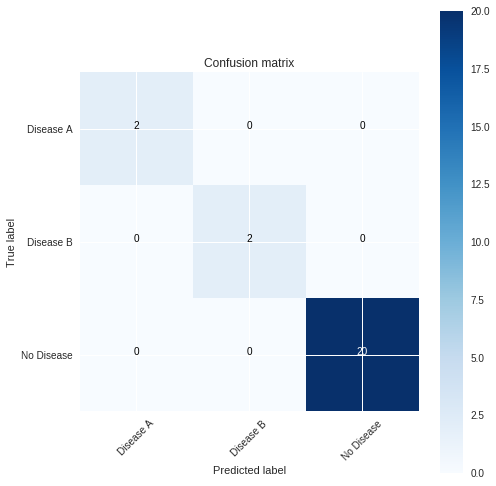

In [31]:
full_report(model.best_clf, X_test, y_test, class_list, clf='rf')

Please check out that the model works well with less features.

### 3.3 Data Augmentation  <a id='3.3'></a>   

The use of data augmentation has already been demonstrated in the field of image recognition. This is my trial to apply similar approach to reproduce the data applying random normal number generation.

In [32]:
process = Preprocess(aug_ratio=100000)
process.fit(dataA, dataB, y_train, y_test, DNAlist)

X_train, y_train = process.augument(DNAinter)
print(X_train.shape)

(1600016, 39)


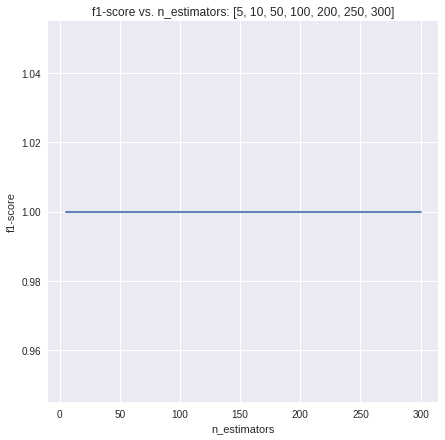

In [33]:
model.fit(X_train, y_train)

# Random Forest
param = [5, 10, 50, 100, 200, 250, 300]

for n in param:
    clf = ensemble.RandomForestClassifier(n_estimators=n)
    model.test(clf, X_test, y_test)

model.plot('n_estimators', param)

Accuracy : 1.0
Classification Report
             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000         2
          1     1.0000    1.0000    1.0000         2
          2     1.0000    1.0000    1.0000        20

avg / total     1.0000    1.0000    1.0000        24



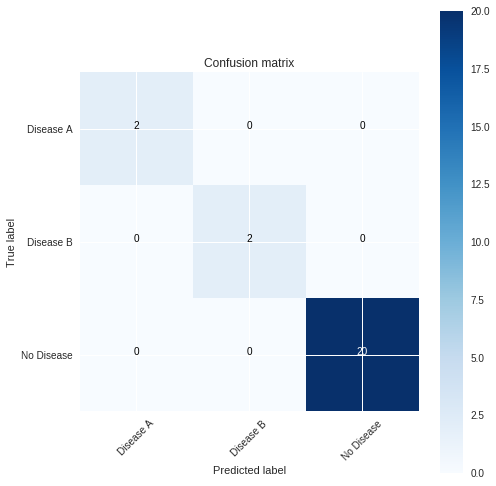

In [34]:
full_report(model.best_clf, X_test, y_test, class_list, clf='rf')

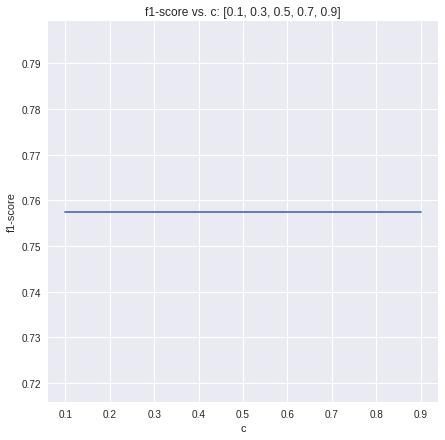

In [35]:
model.fit(X_train, new_y_train)

# SVM
param = [x/10 for x in list(range(1, 11, 2))]

for n in param:
    clf = svm.SVC(C=n)
    model.test(clf, X_test, new_y_test)

model.plot('c', param)

Accuracy : 0.8333333333333334
Classification Report
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000         2
          1     0.0000    0.0000    0.0000         2
          2     0.8333    1.0000    0.9091        20

avg / total     0.6944    0.8333    0.7576        24



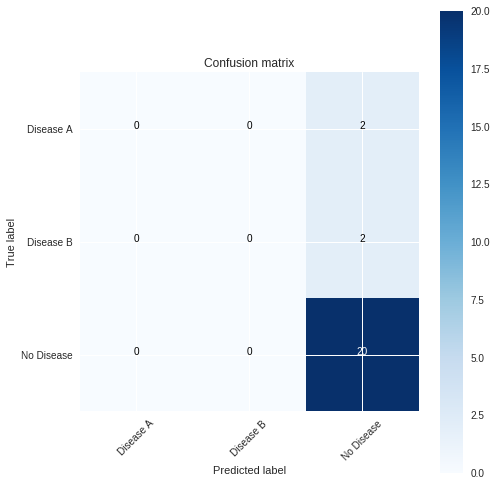

In [36]:
full_report(model.best_clf, X_test, new_y_test, class_list, clf='svm')

At this time, I could not improve the performance of SVM applying the data augmentation. However, you can see the performance of random forest improved with low number of n_estimator parameters. This indicates that the model could be better generalized to unseen data even though we do not have solid evidence with the small test set.

## 4. Unsupervised Learning - Anomaly Detection  <a id='4'></a>   

K-means clustering is applied to detect the anomaly points

In [0]:
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(X_test)

# standardize these 2 new features
scaler = MinMaxScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled, columns = ['principal_feature1', 'principal_feature2'])

In [38]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = 5
kmeans = KMeans(n_clusters=n_cluster).fit(data)

cluster = pd.DataFrame([])
cluster['cluster'] = kmeans.predict(data)
cluster['principal_feature1'] = data.iloc[:,0]
cluster['principal_feature2'] = data.iloc[:,1]
cluster['cluster'].value_counts()

1    11
2     4
0     4
3     3
4     2
Name: cluster, dtype: int64

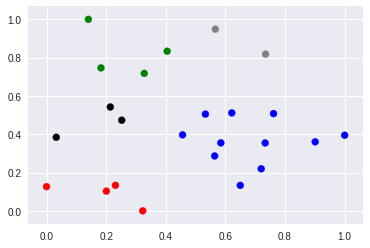

In [39]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'black', 4:'grey', 5:'yellow'}
ax.scatter(cluster['principal_feature1'], cluster['principal_feature2'], c=cluster["cluster"].apply(lambda x: colors[x]))
plt.show()

In [0]:
def get_distance(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [0]:
outliers_fraction = 0.2
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = get_distance(data, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
data['anomaly21'] = (distance >= threshold).astype(int)

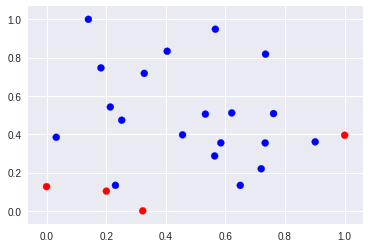

In [42]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(data['principal_feature1'], data['principal_feature2'], c=data["anomaly21"].apply(lambda x: colors[x]))
plt.show()

In [43]:
# Number of anomaly points
sum(map(lambda x: x!=2, new_y_test))

4

             precision    recall  f1-score   support

          0     0.8500    0.8500    0.8500        20
          1     0.2500    0.2500    0.2500         4

avg / total     0.7500    0.7500    0.7500        24



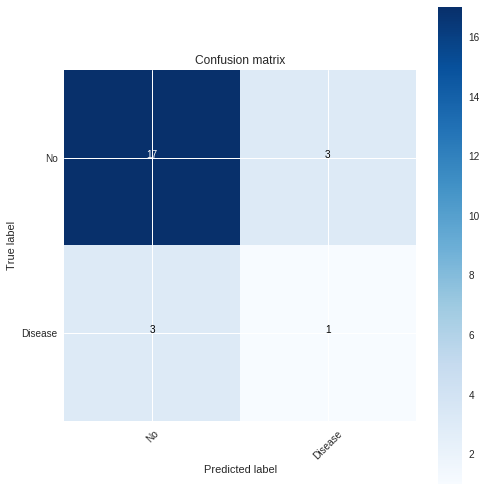

In [44]:
y_pred = data['anomaly21']
y_test = (new_y_test != 2).astype(int)

conf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_mat(conf_mat, classes=['No', 'Disease'])
print(classification_report(y_test, y_pred, digits=4))

### Conclusion:

The supervised models with data augmentation has reasonable performance with flexible models, that is random forest and gradient boosting. However, SVN with less flexibility does not represent the trainig data well. On the unsupervised learning, more data are required to make better performance. This result is intuitive in that the labeled data have more information than unlabeled data. Supervised learning is meant to outperform if only limited size of labeled dataset are given. 